##### Sudden Drift 
Run 1000 simulations of:
 - Day 0-999 &emsp;&nbsp;&nbsp; -  mean 0.86, sigma 0.05 &nbsp;(in-control data)
 - Day 1000-1999 – mean 0.83, sigma 0.05

Save the samples drawn from the distribution for the changepoint detection using CUSUM algorithm. 

In [1]:
%reset -f

In [2]:
# Imports
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm # Colormaps
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import pandas as pd
import dataframe_image as dfi

sns.set_style('darkgrid')
np.random.seed(42)
#
import warnings
warnings.filterwarnings('always') 
warnings.filterwarnings('ignore')

The data for CUSUM-based changepoint detection is the guassian random vairables with mean 0.86 for 1000 days followed by mean of 0.83 for days 1000-2000 with standard deviation 0.05.


In [193]:
# Simulate 2000 days - Samples from s0.86 from day 0-999 and s0.83 from day1000-1999
runs = 0
FalsePos      =  np.array([])
TruePos       =  np.array([])
DelaytoDetect =  np.array([])
FAR           =  np.array([])     #False Alarm Rate
STD_test_AUCs =  np.array([])     #Standard deviation of test AUCs
#DetectionTimes=  np.array([])
DetectionTimes=  np.array([],dtype=int)
D             =  np.array([],dtype=int) #save the Dj which are binary values indicating detection
Z             =  np.array([],dtype=int) #save the Zj = min(Tj,pre-change-days)
AvgDD         = np.array([])      # Average Detection Delay
#Save the in-control and out-of-control specificities - mean in this case
sp_pre           = np.array([])
sp_post          = np.array([])

pre_change_days = 1000
post_change_days = 1000
total_days = pre_change_days + post_change_days
while (runs < 10): #was 13 before # was 10 now 02/06
    #test_days = 0
    test_AUC =  np.array([])
    #print("Sim:",runs)
    mu, sigma = 0.86, 0.05 # mean and standard deviation
    s86 = np.random.normal(mu, sigma, pre_change_days)
    test_AUC = np.append(test_AUC, s86)
    sp_pre   = np.append(sp_pre, s86)    #Combine for histogram
        
    mu, sigma = 0.83, 0.05 # mean and standard deviation
    s83 = np.random.normal(mu, sigma, post_change_days)
    test_AUC = np.append(test_AUC, s83)
    sp_post      = np.append(sp_post, s83)      #Combine for histogram
        
    
    #CUSUM for day0-200: outcomes are detection delay and #FP, #TP
    num_rows = np.shape(test_AUC)[0]
    in_control_auc = test_AUC[:pre_change_days]
    out_control_auc = test_AUC[pre_change_days:total_days]
    std_auc = np.std(out_control_auc)
    x = np.array(test_AUC)

    mu   = np.mean(in_control_auc)
    mu_1 = np.mean(out_control_auc)
    std  = np.std(in_control_auc)
    std_1  = np.std(out_control_auc)
    h    = 0.2    # Upper/lower control limit to detect the changepoint
    k    = 0.05    # Drift 0.05 is the 2 sigma change that we wish to detect, 0.025 - one-sigma change
    
    x_mean = np.zeros(num_rows,dtype=float)
    #S_hi : for positive changes --------------------------
    S_hi = np.zeros(num_rows,dtype=float)
    S_hi[0] = 0.0 # starts with 0
    #Increase in mean = x-mu-k ----------------------------
    mean_hi = np.zeros(num_rows,dtype=float)

    #Decrease in mean = mu-k-x----------------------------
    mean_lo = np.zeros(num_rows,dtype=float)
    #S_lo : for negative changes --------------------------
    S_lo = np.zeros(num_rows,dtype=float)
    S_lo[0] = 0.0 # starts with 0
     #CUSUM: Cumulative sum of x minus mu ------------------
    cusum = np.zeros(num_rows,dtype=float)
    cusum[0] = 0.0 # initialize with 0
    
    for i in range(0, num_rows):
        x_mean[i]  = x[i] - mu  #x_mean 
        mean_hi[i] = x[i] - mu - k
        S_hi[i]    = max(0, S_hi[i-1] + mean_hi[i])
        mean_lo[i] = mu - k - x[i]
        S_lo[i]    = max(0, S_lo[i-1] + mean_lo[i])
        cusum[i]   = cusum[i-1] + x_mean[i]

    x_mean  = np.round(x_mean,decimals=2)
    S_hi    = np.round(S_hi,decimals=2)
    mean_lo = np.round(mean_lo,decimals=2)
    S_lo    = np.round(S_lo,decimals=2)
    cusum   = np.round(cusum,decimals=2)

    signal_hi = np.where(S_hi > h) [0]
    signal_lo = np.where(S_lo < -h)[0]

    # Construct the tabular CUSUM Chart
    chart = np.array([])
    chart = np.column_stack((x.T, x_mean.T, mean_hi.T, S_hi.T, mean_lo.T, S_lo.T, cusum.T))
    np.round(chart, 2)

    #d = 2 *(np.log((1-0.01) / (0.0027)))
    #h = d * 0.5 # h= d*k where k=0.5
    #h = 4 # as per the NIST doc on CUSUM

    #l1 =  np.append(num_rows, data_tabular, axis = 1)
    #l1 = np.concatenate(num_rows.T, data_tabular.T)
    #chart = np.column_stack((num_rows.T, data_tabular.T))
    #chart

    np.set_printoptions(suppress=True, formatter={'float_kind':'{:0.2f}'.format})
    #print("CUSUM Chart is:\n", np.round(chart,decimals=2))
    #x_mean

    df = pd.DataFrame(chart) 
    df.columns = ['X','x-mu','Increase in Mean', 'S_hi', 'Decrease-in-mean', 'S_lo', 'CUSUM']
    #summary_table = pd.DataFrame(columns=["X","X-mu", "Increase in Mean", "S_hi",
    #                                      "Decrease-in-mean", "S_lo", "CUSUM"])
    #summary_table.loc[runs] = [x.T, x_mean.T, mean_hi.T, S_hi.T, mean_lo.T, S_lo.T, cusum.T]
                                            
    #filename = "file%d" %runs
    #df.to_csv(("CUSUM-out/file%d.csv" %runs), sep='\t')    
    #print(df.to_string())
    #print(chart)
    #Export datafrae to png
    #import dataframe_image as dfi
    #dfi.export(df,'CUSUM-out/CUSUM-run.png')
    
    
    # False positives and Total alarms
    falsePos = 0
    alarms   = 0
    delay    = 0
    avddd    = 0   # this is the delay from the paper: td-ts (z_k-v) where v is the changepoint and z_k is the time of detection
    #MTBFA    = 0
    
    
    for i in range(0, pre_change_days):
        if (S_lo[i] > h or S_hi[i] > h):   
            falsePos += 1  #False Positives 
            DetectionTimes= np.append(DetectionTimes, i)   #time at which a false positive is detected
            D = np.append(D, 1)
            Z = np.append(Z, min(i,pre_change_days))
            #print("detection times",DetectionTimes)
            #print("detection times size",DetectionTimes.size)
            break
        #if (S_lo[i] > h):   
            #if (i>100):  
                #alarms += 1        #True Positive: break after detecting one TP
                #delay   = i-100+1    # ts is 100 because the change starts at day100
                #avddd   = i-100
            #break
    if falsePos == 0:
        D = np.append(D, 0)
        #DetectionTimes[runs] = pre_change_days
        Z = np.append(Z, pre_change_days)
    # Delay to detect the first changepoint
    #delay = 0
    for i in range(pre_change_days, total_days):
           if ((S_lo[i] > h)):# or (S_hi[i] > h)):
                alarms += 1        #True Positive: break after detecting one TP
                #delay  = i-1000+1    # ts is 1000 because the change starts at day1000
                avddd  = i-pre_change_days
                break
    
    #Calculate MTBFA(Mean time time between False Alarms)
    #MTBFA = np.mean(DetectionTimes)
    #FlaseAlarmRate = 1/MTBFA
    
    FalsePos      = np.append(FalsePos, falsePos)
    TruePos       = np.append(TruePos, alarms)
    DelaytoDetect = np.append(DelaytoDetect, delay)   # td-ts+1
    #FAR           = np.append(FAR, FlaseAlarmRate)
    #DetectionTimes= np.append(DetectionTimes, detectionTime)
    AvgDD         = np.append(AvgDD, avddd)   # ADD estimate from the paper
    STD_test_AUCs = np.append(STD_test_AUCs, std_auc)
    #print(falsePos)
    runs += 1  # continue until 1000 runs

In [194]:
test_AUC.shape
DelaytoDetect
std
DetectionTimes.size
falsePos
#DetectionTimes[999]
avddd
#print(df.to_string())
#df[999:1030]
df[0:20]
AvgDD
DetectionTimes
AvgDD

array([64.00, 312.00, 316.00, 28.00, 284.00, 32.00, 123.00, 23.00, 1.00,
       400.00])

In [195]:
DetectionTimes

array([], dtype=int64)

In [6]:
print("--------------------------------")
print("Control Limit:\t", h)
print("Reference Value:\t", k)
print("Pre/Post Change Days:\t", pre_change_days)
#print("Samples per day:\t", sample_size)
print("--------------------------------")
print("total number of False Positives:",np.sum(FalsePos))
print("Total True Positives:",np.sum(TruePos))
print("Total False Negatives:",1000-np.sum(TruePos))
print("Average Detection Delay",np.mean(AvgDD))
print("Minimum Delay",np.min(AvgDD))
print("Maximum Delay",np.max(AvgDD))
MTBFA = np.mean(DetectionTimes)
MLP = np.sum(D)/np.sum(Z)
MTBFA_new = 1/MLP
FlaseAlarmRate = 1/MTBFA
print("MTBFA", MTBFA)
print("MTBFA new", MTBFA_new)
print("Flase Alarm Rate", FlaseAlarmRate)
nonZeroAvgDD = AvgDD[np.nonzero(AvgDD)]
#print("Average Detection Delay, ADD from paper is",np.mean(nonZeroAvgDD))
print("standard deviations of the test AUCs is",np.mean(STD_test_AUCs))
print("Simulation days-post_change_days:", post_change_days)

--------------------------------
Control Limit:	 0.2
Reference Value:	 0.03
Pre/Post Change Days:	 1000
--------------------------------
total number of False Positives: 916.0
Total True Positives: 1000.0
Total False Negatives: 0.0
Average Detection Delay 26.612
Minimum Delay 0.0
Maximum Delay 255.0
MTBFA 312.7401746724891
MTBFA new 404.44323144104806
Flase Alarm Rate 0.003197542500087269
standard deviations of the test AUCs is 0.049982453452780996
Simulation days-post_change_days: 1000


<function matplotlib.pyplot.show(close=None, block=None)>

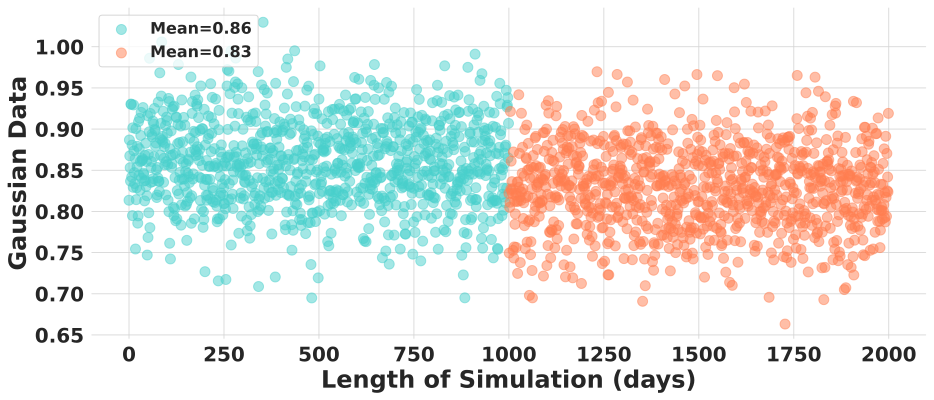

In [17]:
from matplotlib import rcParams
# PLOT THE Gaussian samples
fig, ax = plt.subplots(figsize=(15, 6))
rcParams['font.weight'] = 'bold'

y1 = np.arange(pre_change_days)
x1 = test_AUC[:pre_change_days]
plt.scatter(y1, x1, c='mediumturquoise', s=100, alpha=0.5, label='Mean=0.86')
y2 = np.arange(pre_change_days, total_days, 1)
x2 = test_AUC[pre_change_days:total_days]
plt.scatter(y2, x2, c='coral', s=100, alpha=0.5, label='Mean=0.83')
#plt.plot(data83, len(data86) * [1], "o")
#plt.axhline(y = threshold, color = 'lightgrey', linestyle = '--', linewidth=1.0, label='Threshold=1.08032')
ax.legend(fontsize=16) #frameon=False
rcParams["legend.loc"] = 'upper left'
plt.rcParams['axes.facecolor'] = 'white'
#plt.title('Samples drawn from two Gaussians')
ax.set_xlabel('Length of Simulation (days)', fontsize=24, fontweight='bold')
ax.set_ylabel('Gaussian Data', fontsize=24, fontweight='bold')
# changing the fontsize of yticks
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
#plt.grid(visible=None)
ax.grid(True, color='lightgrey')
plt.show

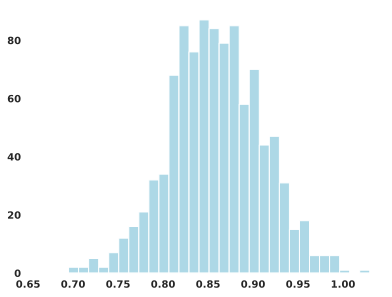

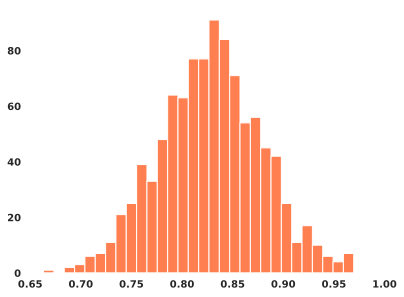

In [8]:
# PLOT THE HISTOGRAM OF AUCs

mu   = np.mean(in_control_auc)
mu_1 = np.mean(out_control_auc)
std  = np.std(in_control_auc)
std_1  = np.std(out_control_auc)

#Display the histogram of in-control AUC, along with the probability density function
import matplotlib.pyplot as plt
count, bins, ignored = plt.hist(in_control_auc, 30, color = "lightblue")
#plt.plot(bins, 1/(std * np.sqrt(2 * np.pi)) *
#               np.exp( - (bins - mu)**2 / (2 * std**2) ),
#         linewidth=2, color='r')
plt.rcParams['axes.facecolor'] = 'white'
plt.xticks([0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95,1.0])
plt.grid(visible=None)
plt.show()

#Display the histogram of out-of-control AUC, along with the probability density function
import matplotlib.pyplot as plt
count, bins, ignored = plt.hist(out_control_auc, 30, color = "coral")
#plt.plot(bins, 1/(std_1 * np.sqrt(2 * np.pi)) *
#               np.exp( - (bins - mu_1)**2 / (2 * std_1**2) ),
#         linewidth=2, color='r')
plt.rcParams['axes.facecolor'] = 'white'
plt.xticks([0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95,1.0])
plt.grid(visible=None)
plt.show()

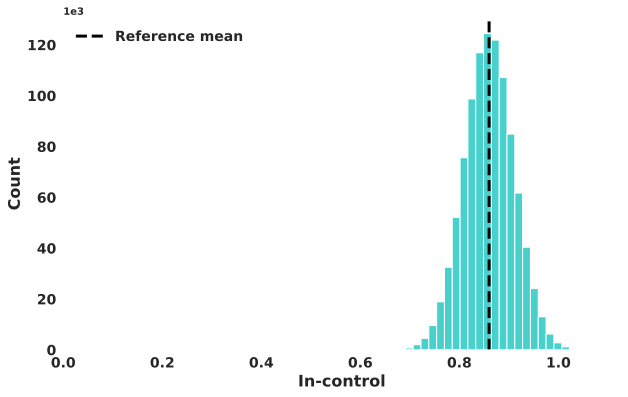

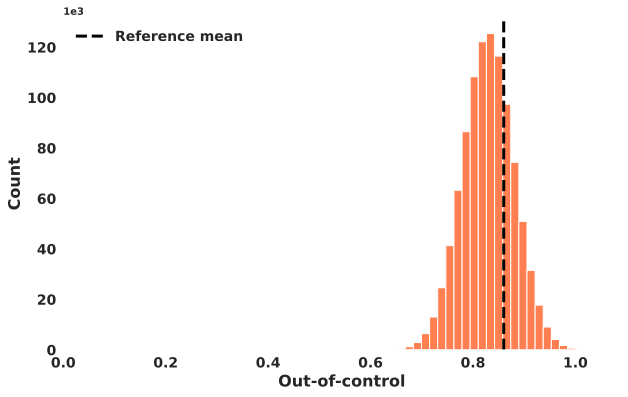

In [21]:
# PLOT THE HISTOGRAM OF all AUCs - all the AUCs for 1000 simulations * 1000 days 

#Display the histogram of in-control AUC, along with the probability density function
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 6))
count, bins, ignored = plt.hist(sp_pre, 30, color = "mediumturquoise")
#plt.plot(bins, 1/(std * np.sqrt(2 * np.pi)) *
#               np.exp( - (bins - mu)**2 / (2 * std**2) ),
#         linewidth=2, color='r')
plt.rcParams['axes.facecolor'] = 'white'
plt.grid(visible=None)
#ax.grid(True, color='lightgrey')  # Black grid lines
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.axvline(x=0.86, color='black', linestyle='--', label='Reference mean', linewidth=3.0)  
ax.set_xlabel('In-control', fontsize=16, fontweight='bold')
ax.set_ylabel('Count', fontsize=16, fontweight='bold')
ax.legend(fontsize=14,  frameon=False)
rcParams["legend.loc"] = 'upper left'
#plt.xticks([0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95])
#plt.title('mean=0.86',fontsize=14)
plt.yticks(fontsize=14)
plt.ticklabel_format(style='sci', axis='y', scilimits=(3,3))
plt.xticks(fontsize=14)
plt.show()

#Display the histogram of out-of-control AUC, along with the probability density function
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 6))
count, bins, ignored = plt.hist(sp_post, 30, color = "coral")
#plt.plot(bins, 1/(std_1 * np.sqrt(2 * np.pi)) *
#               np.exp( - (bins - mu_1)**2 / (2 * std_1**2) ),
#         linewidth=2, color='r')
plt.rcParams['axes.facecolor'] = 'white'
plt.grid(visible=None)
#ax.grid(True, color='lightgrey')  # Black grid lines
#plt.xticks([0.725, 0.750, 0.775, 0.800, 0.825, 0.850, 0.875, 0.900, 0.925, 0.950])
#plt.xticks([0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95])
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.axvline(x=0.86, color='black', linestyle='--', label='Reference mean', linewidth=3.0)
ax.set_xlabel('Out-of-control', fontsize=16, fontweight='bold')
ax.set_ylabel('Count', fontsize=16, fontweight='bold')
ax.legend(fontsize=14, frameon=False)
rcParams["legend.loc"] = 'upper left'
plt.yticks(fontsize=14)
plt.ticklabel_format(style='sci', axis='y', scilimits=(3,3))
plt.xticks(fontsize=14)
#plt.title('mean=0.83', fontsize=15)
plt.show()

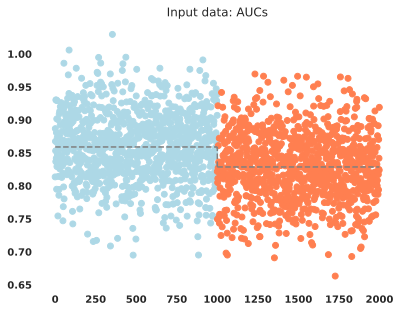

In [10]:
#Plot the AUCs
pre_change_days  = 1000
post_change_days = 1000
total_days       = pre_change_days + post_change_days
plt.rcParams['axes.facecolor'] = 'white'
plt.grid(b=None)
y1 = np.arange(pre_change_days)
x1 = test_AUC[:pre_change_days]
plt.scatter(y1, x1, c='lightblue')
y2 = np.arange(pre_change_days, total_days, 1)
x2 = test_AUC[pre_change_days:total_days]
plt.scatter(y2, x2, c='coral')
plt.hlines(y = mu, xmin=0, xmax=pre_change_days,color = 'grey', linestyle = '--')
plt.hlines(y = mu_1, xmin=pre_change_days, xmax=total_days,color = 'grey', linestyle = '--')
# single vline with specific ymin and ymax
plt.vlines(x=pre_change_days, ymin=mu_1, ymax=mu, colors='grey', linestyle = '--')
#yline(0.86)
#plt.plot(test_AUC, 'go')


plt.title('Input data: AUCs')
plt.show()

In [11]:
print("mu_0:",mu)
print("mu_1",mu_1)
print("std - in-control",std)
print("std - out-of-control", std_1)
delta=(k/std)*2
delta

mu_0: 0.8589725849479906
mu_1 0.828666890003407
std - in-control 0.0511048718002225
std - out-of-control 0.05042068712876155


1.174056364617253

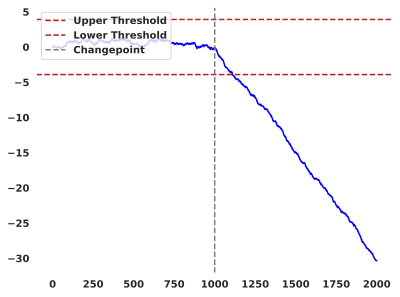

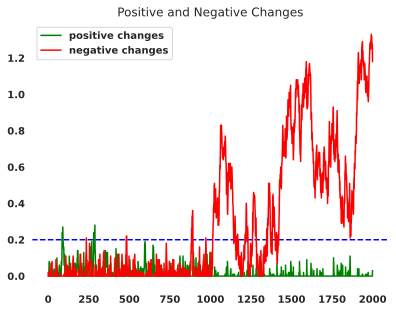

In [12]:
#CUSUM
plt.plot(cusum, '-b')
# Plot control limits
plt.axhline(h/std, color='firebrick', linestyle='--', label='Upper Threshold')  
plt.axhline(-h/std, color='firebrick', linestyle='--', label='Lower Threshold')  
# Indicate the start of the shift
plt.axvline(x=1000, color='grey', linestyle='--', label='Changepoint')  
#plt.set_xlabel('Length of simulation')
#plt.set_ylabel('Cumulative Sum')
#plt.title('Cumulative Sum')
plt.legend()
plt.show()

# specifying horizontal line type
plt.axhline(y = 0.2, color = 'b', linestyle = '--')
plt.plot(S_hi,  '-g', label='positive changes')
plt.plot(S_lo, '-r', label='negative changes')
plt.title('Positive and Negative Changes')
plt.legend()
plt.show()

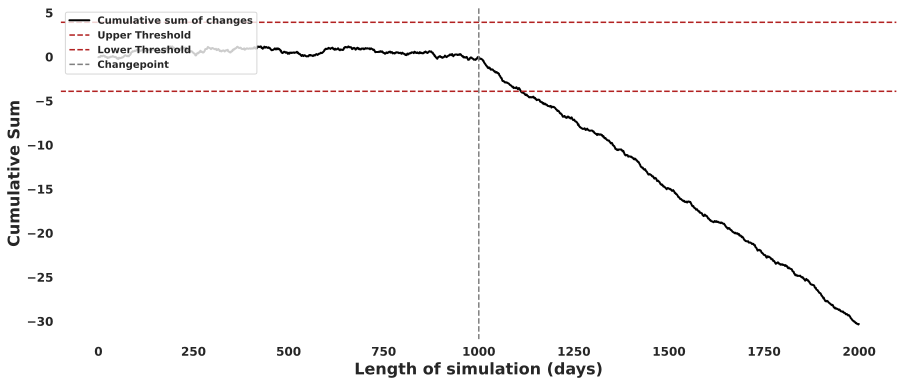

In [13]:
from matplotlib import rcParams

fig, ax = plt.subplots(figsize=(15, 6))
rcParams['font.weight'] = 'bold'

ax.plot(cusum, '-k', linewidth=2, label='Cumulative sum of changes')
# Plot control limits
ax.axhline(h/std, color='firebrick', linestyle='--', label='Upper Threshold')  
ax.axhline(-h/std, color='firebrick', linestyle='--', label='Lower Threshold')  
# Indicate the start of the shift
ax.axvline(x=1000, color='grey', linestyle='--', label='Changepoint')  
#for i, val in enumerate(cusum):
#    if val > h/std or val < -h/std:
#        ax.scatter(i, val, color='black', marker='o', s=20)  #  out-of-control points
ax.set_xlabel('Length of simulation (days)', fontsize=16, fontweight='bold')
ax.set_ylabel('Cumulative Sum', fontsize=16, fontweight='bold')
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)


#plt.title('Cumulative Sum')
legend_properties = {'weight':'bold'}
ax.legend(prop=legend_properties)
plt.show()

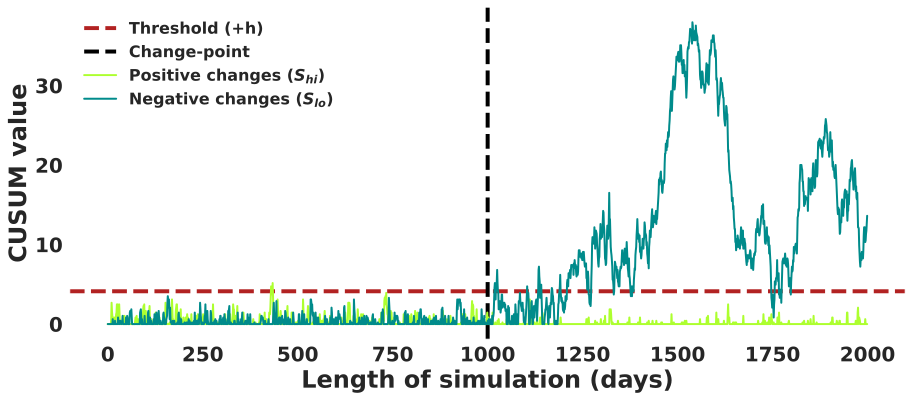

In [121]:
#Plot CUSUM of positive and negative changes
from matplotlib import rcParams


fig, ax = plt.subplots(figsize=(15, 6))
rcParams['font.weight'] = 'bold'
# Plot control limits
ax.axhline(h/std, color='firebrick', linestyle='--', label='Threshold (+h)', linewidth=4.0)  
# Indicate the start of the shift
ax.axvline(x=1000, color='black', linestyle='--', label='Change-point', linewidth=4.0)  
#ax.axhline(-h/std, color='firebrick', linestyle='--', label='Lower Threshold') 
#ax.plot(S_hi/std,  'greenyellow', label='positive changes')
ax.plot(S_hi/std,  'greenyellow', label='Positive changes ($S_{hi}$)', linewidth=2.0)
#ax.plot(S_hi/std,  'blueviolet', label='positive changes')
#ax.plot(S_lo/std, 'darkcyan', label='negative changes')
ax.plot(S_lo/std, 'darkcyan', label='Negative changes ($S_{lo}$)', linewidth=2.0)
#ax.plot(S_lo/std, 'skyblue', label='negative changes')
#for i, val in enumerate(S_lo/std):
#    if val > h/std and i>1000:
#        ax.scatter(i, val, color='darkcyan', marker='o', s=20)  #  True Positivies
#for i, val in enumerate(S_hi/std):
#    if val > h/std and i<1000:
#        ax.scatter(i, val, color='red', marker='o', s=20)       #  False Positivies
#for i, val in enumerate(S_lo/std):
#    if val > h/std and i<1000:
#       ax.scatter(i, val, color='red', marker='o', s=20)       #  False Positivies
#ax.scatter(signal_hi, [S_hi[i]/std for i in signal_hi], color='black', zorder=5, label='Detected Shift') 
#ax.scatter(signal_lo, [S_lo[i]/std for i in signal_lo], color='black', zorder=5)

# Update the legend
legend_elements = [#plt.Line2D([0], [0], color='darkcyan',     marker='o',  label='True Detections'),
                   #plt.Line2D([0], [0], color='red',       marker='o',     label='False Detections'),
                   plt.Line2D([0], [0], color='firebrick', linestyle='--', label='Threshold (+h)'),
                   plt.Line2D([0], [0], color='black',      linestyle='--', label='Change-point'),
                   plt.Line2D([0], [0], color='greenyellow',               label='Positive changes ($S_{hi}$)'),
                   plt.Line2D([0], [0], color='darkcyan',                  label='Negative changes ($S_{lo}$)')
                  ]
legend_properties = {'weight':'bold'}
ax.legend(handles=legend_elements,prop=legend_properties)
ax.set_xlabel('Length of simulation (days)', fontsize=24, fontweight='bold')
ax.set_ylabel('CUSUM value', fontsize=24, fontweight='bold')
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
plt.rcParams['axes.facecolor'] = 'white'
plt.grid(visible=None)
#ax.legend()
ax.legend(fontsize=16, frameon=False)
rcParams["legend.loc"] = 'upper left'
plt.show()